# Continued exploration of potential problem with EE model

Previously I've found an example that [works well with EZ model](https://gaow.github.io/mvarbvs/analysis/20190627_two_snps_dispute_missing_data.html), [roughly works with EE model for a slighly modified simulation data-set](https://gaow.github.io/mvarbvs/analysis/20190627_EE_model_no_problem.html) but [does not work with EE model on this data-set](https://gaow.github.io/mvarbvs/analysis/20190627_EE_model_problem.html). Here I am trying to explore the problem a bit more, without implementing and checking for ELBO yet.

**Note: my previous code has an error in the line `e = MASS::mvrnorm(1, rep(0,R), diag(R) * 1)` that only generated 6 numbers, and were added cyclicly to `g` to make `y`. That breaks things. After I fix the line to using `nrow(g)` I no longer can reproduce the problem as drastic as it was shown in the notebooks above.**

In [1]:
setwd("/home/gaow/tmp/13-May-2019")

## Set up the simulation

Copying codes from previous notebooks.

In [2]:
genotype = readRDS('Multi_Tissues.ENSG00000145214.RDS')$X
P = ncol(genotype)
R = 6
eff_factor = 1.5
snp1 = 184
snp2 = 354
set.seed(1)
b = matrix(0, P, R)
coef_value = b[which(apply(b,1,sum)!=0),]
sharing = matrix(0.75, (R/2), (R/2))
diag(sharing) = 1
b[snp1, 1:(R/2)] = abs(MASS::mvrnorm(1, rep(0,(R/2)), sharing)) / eff_factor
b[snp2, (R/2+1):R] = -abs(MASS::mvrnorm(1, rep(0,(R/2)), sharing)) / eff_factor
g = genotype %*% b
e = MASS::mvrnorm(nrow(g), rep(0,R), diag(R) * 1)
Y = g + e
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))

In [3]:
U1 = matrix(0,R,R)
U1[1:(R/2),1:(R/2)] = sharing
U2 = matrix(0,R,R)
U2[(R/2+1):R,(R/2+1):R] = sharing
Ulist = list(U1=U1, U2=U2)
scaling = c(0.5,1) / eff_factor

## EE model setup

In [4]:
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 0)

## Only fit the residual

In [5]:
start_time <- Sys.time()
res = mmbr::susie(genotype, e,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 2.293989 mins


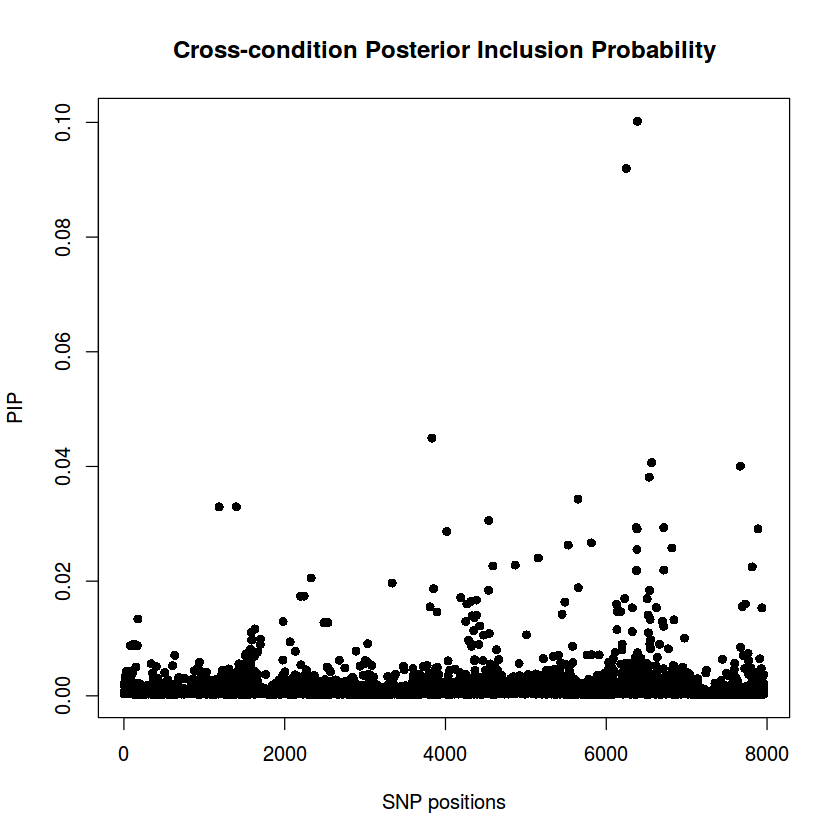

In [6]:
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)

## Fit the simulated responses

In [7]:
start_time <- Sys.time()
res2 = mmbr::susie(genotype, Y,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 3.181872 mins


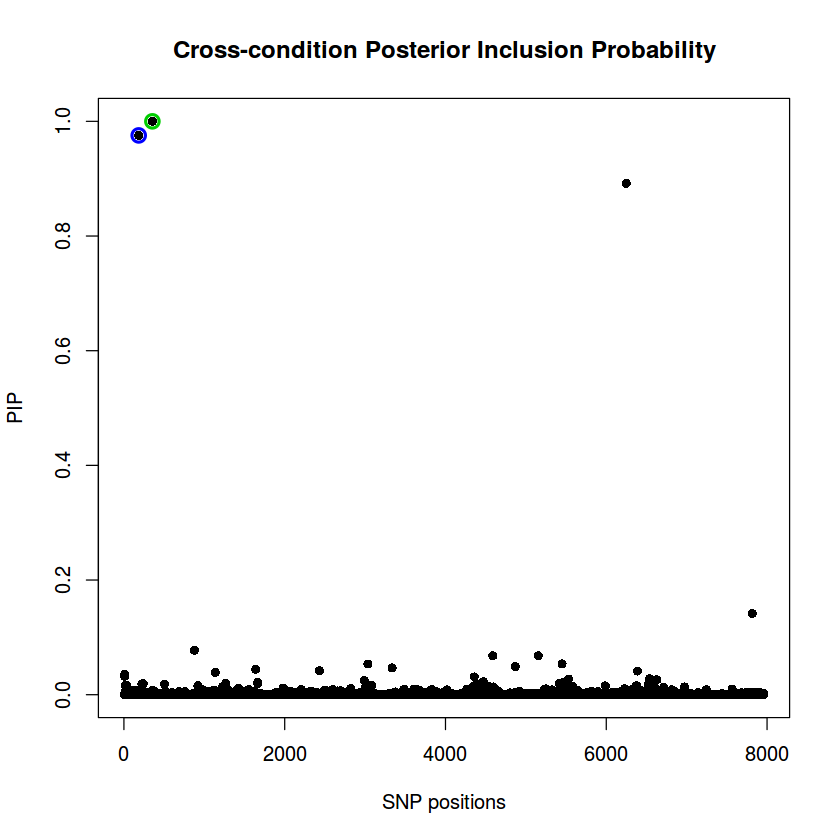

In [8]:
susieR::susie_plot(res2,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)

In [9]:
res2$pip[snp1]

[1] 0.9754529

In [10]:
res2$pip[snp2]

[1] 1

The signals are captured, but there seems to be a false signal at position 6000+. 

## EZ model setup

In [11]:
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 1)

## Only fit the residual

In [12]:
start_time <- Sys.time()
res = mmbr::susie(genotype, e,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 4.227734 secs


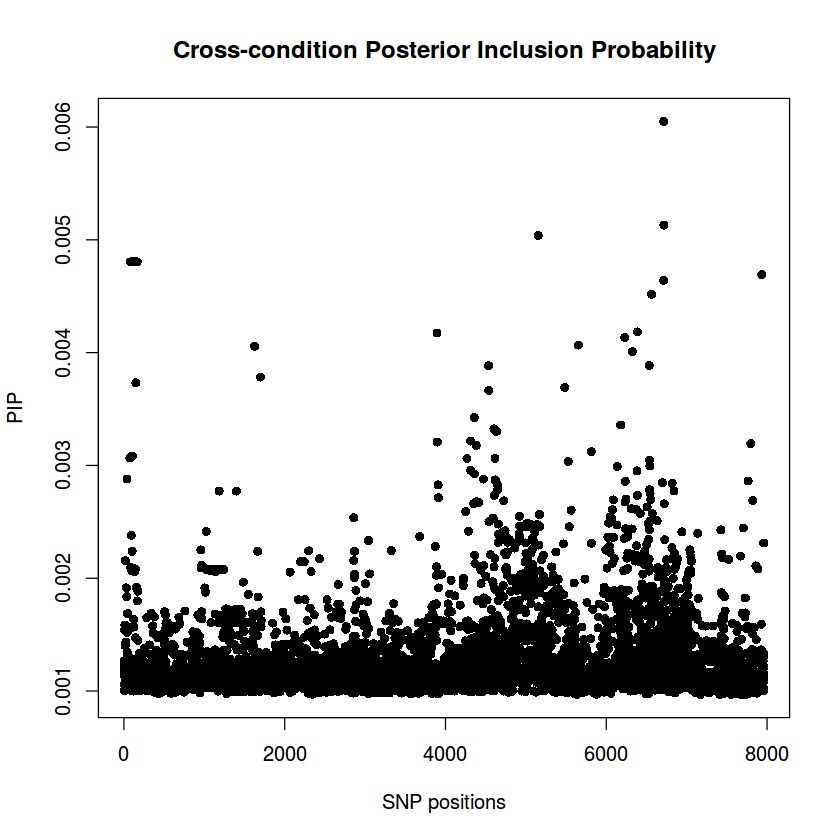

In [13]:
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)

## Fit the simulated responses

In [14]:
start_time <- Sys.time()
res2 = mmbr::susie(genotype, Y,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 25.00285 secs


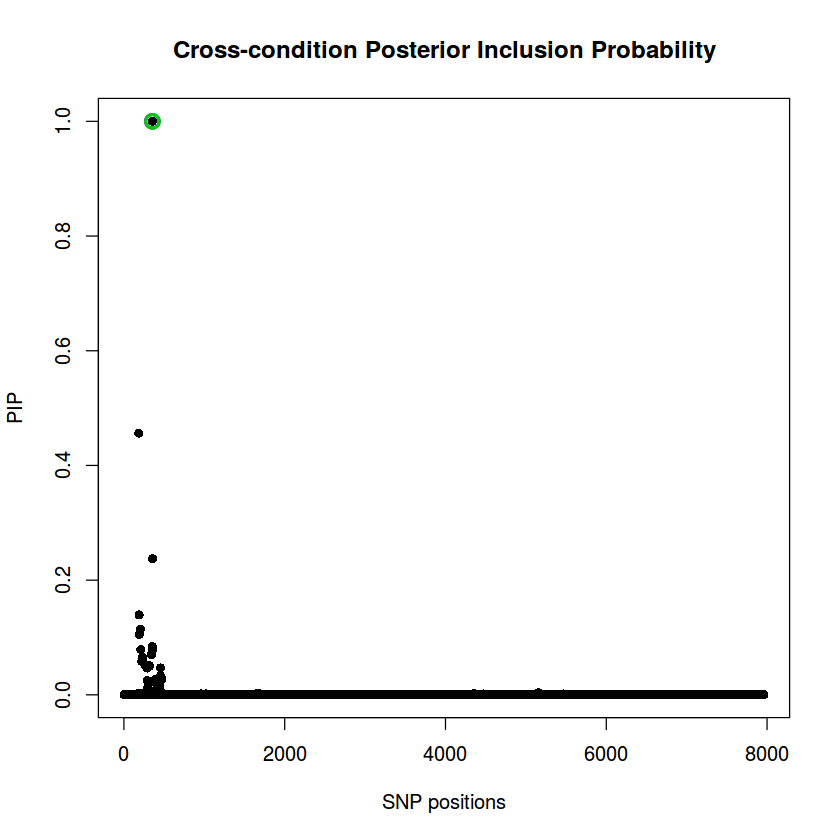

In [15]:
susieR::susie_plot(res2,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)

In [16]:
res2$pip[snp1]

[1] 0.4562568

In [17]:
res2$pip[snp2]

[1] 1

Although the 2nd SNP did not make into the CS, there is no false positives.